In [28]:
import numpy as np
import os
import tqdm
from scipy.signal import stft

from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from PIL import Image
import tqdm

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor

# Transformers (Hugging Face CLIP)
from transformers import CLIPModel, CLIPProcessor

# Scikit-learn
from sklearn.linear_model import RidgeClassifier

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import torchmetrics
from torchmetrics import Accuracy

!pip install monai
import monai
from monai.networks import nets
from torchsummary import summary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

eeg_data_train= np.load('/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-01/sub-01/preprocessed_eeg_training.npy', allow_pickle=True).item()
img_metadata = np.load("/kaggle/input/things-eeg-2-images/image_metadata.npy",
	allow_pickle=True).item()

eeg_path=["/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-01/sub-01/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-02/sub-02/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-03/sub-03/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-04/sub-04/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-05/sub-05/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-06/sub-06/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-07/sub-07/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-08/sub-08/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-09/sub-09/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-10/sub-10/preprocessed_eeg_training.npy"
         ]

In [29]:
train_img_idx =  10 #@param {type:"integer"}

# eeg_data_single_image = eeg_data_train['preprocessed_eeg_data'][train_img_idx]

img_parent_dir='/kaggle/input/things-eeg-2-images/training_images'
train_img_dir= os.path.join(img_parent_dir, 'training_images',
	img_metadata['train_img_concepts'][train_img_idx],
	img_metadata['train_img_files'][train_img_idx])


train_img = Image.open(train_img_dir).convert('RGB')

In [30]:
# Initialize empty lists
real_train_img_idx = []
real_valid_img_idx = []
real_test_img_idx = []

random.seed(42)

# Process each group of 10 numbers (0-9, 10-19, ..., 90-99)
for group_start in range(0, 100, 10):
    group = list(range(group_start, group_start + 10))
    random.shuffle(group)
    
    # Take 1 for validation, 1 for test, and 8 for training from each group
    real_valid_img_idx.append(group[0])
    real_test_img_idx.append(group[1])
    real_train_img_idx.extend(group[2:10])

# Verify the results
print(f"Train: {len(real_train_img_idx)} numbers")  # 80
print(f"Valid: {len(real_valid_img_idx)} numbers")  # 10  
print(f"Test: {len(real_test_img_idx)} numbers")    # 10
print(f"All unique: {len(set(real_train_img_idx + real_valid_img_idx + real_test_img_idx)) == 100}")

Train: 80 numbers
Valid: 10 numbers
Test: 10 numbers
All unique: True


In [31]:
import numpy as np
import scipy.signal as signal
from scipy import ndimage

def augment_eeg(eeg_sample):
    """
    Apply multiple augmentations to a single EEG sample
    Input shape: (4, 17, 100)
    Output shape: (6, 4, 17, 100) - original + 5 augmentations
    """
    augmented_data = []
    
    # # 1. Gaussian noise
    # noisy_sample = add_gaussian_noise(eeg_sample)
    # augmented_data.append(noisy_sample)
    
    # 2. Time warping
    warped_sample = time_warp(eeg_sample)
    augmented_data.append(warped_sample)
    
    # # 3. Channel dropout
    # dropout_sample = channel_dropout(eeg_sample)
    # augmented_data.append(dropout_sample)
    
    # # 4. Frequency filtering variations
    # filtered_sample = frequency_variation(eeg_sample)
    # augmented_data.append(filtered_sample)
    
    # # 5. Amplitude scaling
    # scaled_sample = amplitude_scaling(eeg_sample)
    # augmented_data.append(scaled_sample)
    
    return augmented_data

def add_gaussian_noise(sample, noise_level=0.01):
    """Add Gaussian noise to EEG signal"""
    noise = np.random.normal(0, noise_level, sample.shape)
    return sample + noise

def time_warp(sample, warp_factor=0.1):
    """Apply time warping to EEG signals"""
    n_channels, n_electrodes, n_timepoints = sample.shape
    warped_sample = np.zeros_like(sample)
    
    for c in range(n_channels):
        for e in range(n_electrodes):
            # Create warping function
            warp_points = np.linspace(0, n_timepoints-1, num=5)
            warp_values = np.random.uniform(-warp_factor, warp_factor, 5)
            warp_function = np.interp(np.arange(n_timepoints), warp_points, warp_values)
            
            # Apply warping
            warped_timepoints = np.arange(n_timepoints) + warp_function * n_timepoints
            warped_timepoints = np.clip(warped_timepoints, 0, n_timepoints-1)
            
            warped_sample[c, e] = np.interp(np.arange(n_timepoints), 
                                           warped_timepoints, 
                                           sample[c, e])
    
    return warped_sample

def channel_dropout(sample, dropout_prob=0.2):
    """Randomly dropout some channels"""
    n_channels, n_electrodes, n_timepoints = sample.shape
    mask = np.random.binomial(1, 1-dropout_prob, (n_channels, n_electrodes, 1))
    return sample * mask

def frequency_variation(sample, lowcut=0.5, highcut=30.0, fs=100):
    """Apply random frequency filtering variations"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Randomly vary filter parameters
    random_low = np.random.uniform(lowcut * 0.8, lowcut * 1.2)
    random_high = np.random.uniform(highcut * 0.9, highcut * 1.1)
    
    b, a = signal.butter(4, [random_low/nyquist, random_high/nyquist], btype='band')
    
    filtered_sample = np.zeros_like(sample)
    for c in range(sample.shape[0]):
        for e in range(sample.shape[1]):
            filtered_sample[c, e] = signal.filtfilt(b, a, sample[c, e])
    
    return filtered_sample

def amplitude_scaling(sample, scale_range=(0.8, 1.2)):
    """Randomly scale amplitude of signals"""
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return sample * scale_factor

In [32]:
eeg_train=[]
eeg_val=[]
eeg_test=[]

subject_train=[]
subject_val=[]
subject_test=[]


img_train=[]
img_val=[]
img_test=[]

label_train=[]
label_val=[]
label_test=[]

label_train_encoded=[]
label_val_encoded=[]
label_test_encoded=[]

augmentation_number=1
img_idx_train_list=[]
img_idx_val_list=[]
img_idx_test_list=[]

for sub in range(10):
    eeg_data_train= np.load(eeg_path[sub], allow_pickle=True).item()
    for i in real_train_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_train.append(eeg)
        img_train.append(img_name)   #image name is really the file address 
        label_train.append(label)
        label_train_encoded.append(class_name)
        subject_train.append(subject)
        img_idx_train_list.append(img_idx)
        # eeg=augment_eeg(eeg)
        # eeg_train.extend(eeg)

        # for n in range(augmentation_number):
        #     img_idx=i
        #     img_name=os.path.join(img_parent_dir, 'training_images',
        # 	      img_metadata['train_img_concepts'][i],
        # 	       img_metadata['train_img_files'][i])
        #     label=img_metadata['train_img_concepts'][i]
        #     class_name=int(label.split('_', 1)[0]) - 1
        #     subject=0
        
           
        #     img_train.append(img_name)   #image name is really the file address 
        #     label_train.append(label)
        #     label_train_encoded.append(class_name)
        #     subject_train.append(subject)
        #     img_idx_train_list.append(img_idx)
                
    
    
    
    for i in real_valid_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_val.append(eeg)
        img_val.append(img_name)   #image name is really the file address 
        label_val.append(label)
        label_val_encoded.append(class_name)
        subject_val.append(subject)
        img_idx_val_list.append(img_idx)
    
    for i in real_test_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_test.append(eeg)
        img_test.append(img_name)   #image name is really the file address 
        label_test.append(label)
        label_test_encoded.append(class_name)
        subject_test.append(subject)
        img_idx_test_list.append(img_idx)


In [33]:

spectro_train=[]
spectro_val=[]
spectro_test=[]


# Process training data
for eeg in tqdm.tqdm(eeg_train, desc="Processing train data"):
    sample_spectrograms = []
    
    # Iterate through session number (4) and channels (17)
    for freq_band in range(eeg.shape[0]):  # 4 sessions
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            # Apply STFT to each channel's time series (100 time points)
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_train.append(torch.tensor(np.stack(sample_spectrograms)))

# Process validation data
for eeg in tqdm.tqdm(eeg_val, desc="Processing validation data"):
    sample_spectrograms = []
    
    for freq_band in range(eeg.shape[0]):  # 4 frequency bands
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_val.append(torch.tensor(np.stack(sample_spectrograms)))

# Process test data
for eeg in tqdm.tqdm(eeg_test, desc="Processing test data"):
    sample_spectrograms = []
    
    for freq_band in range(eeg.shape[0]):  # 4 frequency bands
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_test.append(torch.tensor(np.stack(sample_spectrograms)))

# Stack all spectrograms
spectro_train = torch.stack(spectro_train)
spectro_val = torch.stack(spectro_val)
spectro_test = torch.stack(spectro_test)

print(f"Training spectrograms shape: {spectro_train.shape}")
print(f"Validation spectrograms shape: {spectro_val.shape}")
print(f"Test spectrograms shape: {spectro_test.shape}")

Processing test data: 100%|██████████| 100/100 [00:01<00:00, 69.97it/s]

Training spectrograms shape: torch.Size([800, 4, 17, 21, 6])
Validation spectrograms shape: torch.Size([100, 4, 17, 21, 6])
Test spectrograms shape: torch.Size([100, 4, 17, 21, 6])


In [35]:
import ast
import pandas as pd

df = pd.read_csv('/kaggle/input/clip-laion-clip-vit-h-14-laion2b-s32b-b79k/only_text_laion_CLIP-ViT-H-14-laion2B-s32B-b79K_embeddings.csv')
idx_to_embedding = dict(zip(df['idx'], df['clip_img_embeds']))
train_clip_img_embed=[]
val_clip_img_embed=[]
test_clip_img_embed=[]
for p in range(len(eeg_train)):
    target_idx = img_idx_train_list[p]
    train_clip_one = idx_to_embedding[target_idx]
    train_clip_img_embed.append(torch.tensor(ast.literal_eval(train_clip_one))) 
train_clip_img_embeds = torch.stack(train_clip_img_embed)  


for p in range(len(eeg_val)):
    target_idx = img_idx_val_list[p]
    val_clip_one = idx_to_embedding[target_idx]
    val_clip_img_embed.append(torch.tensor(ast.literal_eval(val_clip_one)))
val_clip_img_embeds = torch.stack(val_clip_img_embed)    


for p in range(len(eeg_test)):
    target_idx = img_idx_test_list[p]
    test_clip_one = idx_to_embedding[target_idx]
    test_clip_img_embed.append(torch.tensor(ast.literal_eval(test_clip_one)))
test_clip_img_embeds = torch.stack(test_clip_img_embed)

In [36]:
train_clip_img_embeds.shape
print(np.unique(label_train_encoded))

[0 1 2 3 4 5 6 7 8 9]


In [37]:
batch=8
class LinearClassifier(pl.LightningModule):
    def __init__(self,n_classes, lr=3e-4):
        super(LinearClassifier, self).__init__()

        self.n_classes = n_classes
        self.lr = lr

        self.fc = nn.LazyLinear( n_classes)

        self.loss = nn.CrossEntropyLoss()
       


    def forward(self, x):
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self.forward(inputs)
        loss = self.loss(logits, targets.long())

        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        acc = torch.sum(preds == targets).item() / targets.size(0)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self.forward(inputs)
        loss = self.loss(logits, targets.long())

        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        acc = torch.sum(preds == targets).item() / targets.size(0)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

clip_head_classifier=LinearClassifier(n_classes=10)

clip_features_train_dataset=torch.utils.data.TensorDataset(train_clip_img_embeds[:,:],torch.tensor(label_train_encoded, dtype=torch.long))
clip_features_val_dataset=torch.utils.data.TensorDataset(val_clip_img_embeds[:,:],torch.tensor(label_val_encoded, dtype=torch.long))
# clip_features_test_dataset=torch.utils.data.TensorDataset(test_clip_img_embeds[:,0,:],torch.tensor(label_test))

# Create dataloaders
train_loader = DataLoader(clip_features_train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(clip_features_val_dataset, batch_size=batch)
#test_loader = DataLoader(clip_features_test_dataset, batch_size=batch)

trainer = Trainer(devices=1,max_epochs=5)
trainer.fit(clip_head_classifier, train_loader, val_loader)




Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [141]:

class CNNClassifier(pl.LightningModule):
    def __init__(self, cnn_model,teaching_clip_head=None, lr=1e-3,scale=1., distill_knowledge=True):
        super(CNNClassifier, self).__init__()

        self.cnn_model = cnn_model
        self.teaching_clip_head=teaching_clip_head
        self.lr = lr
        self.scale=scale
        self.softmax=torch.nn.Softmax(-1)
        self.distill_knowledge=distill_knowledge

        self.accuracy = Accuracy(task='multiclass', num_classes=8)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x):
        return self.cnn_model(x)

    def training_step(self, batch, batch_idx):
        inputs, features, targets = batch
        outputs = self.forward(inputs)
        
        loss_base = self.loss(outputs,targets.long())

        if self.distill_knowledge:
            alpha=0.2
            teacher_outputs=self.teaching_clip_head(features)

            outputs_prob=self.softmax(outputs)
        
            teacher_prob=self.softmax(teacher_outputs)

            loss_teacher = self.loss(outputs_prob, teacher_prob)*self.scale
            loss_base = self.loss(outputs,targets.long())

            loss = 0.3*loss_base + 0.3*loss_teacher
        else:
            loss = loss_base
        _, predicted = torch.max(outputs, 1)
        acc = torch.sum(predicted == targets).item() / targets.size(0)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        spectro, feat, targets = batch
        outputs = self(spectro)
        outputs_prob = self.softmax(outputs)
        
        if self.distill_knowledge:
            teacher_outputs = self.teaching_clip_head(feat)
            teacher_prob = self.softmax(teacher_outputs)
            
            # Fix: Use KL divergence for knowledge distillation instead of CrossEntropyLoss
            # CrossEntropyLoss expects class indices, not probability distributions
            # loss_teacher = F.kl_div(
            #     F.log_softmax(outputs, dim=-1), 
            #     teacher_prob, 
            #     reduction='batchmean'
            # ) 

            T = 5 
            loss_teacher = F.kl_div(
                F.log_softmax(outputs / T, dim=-1),
                F.softmax(teacher_outputs / T, dim=-1),
                reduction='batchmean'
            ) * (T * T)

            
            loss_base = self.loss(outputs, targets.long())
        else:
            loss_base = self.loss(outputs, targets.long())
            loss_teacher = 0
        
        loss = loss_base + loss_teacher
        acc = self.accuracy(outputs_prob, targets.long())















        
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss


        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=1e-2)
        return optimizer

In [142]:


class KnowledgeClassifierDataset(torch.utils.data.Dataset):
    def __init__(self,spectro,features,labels,spec_transform=None):
        super().__init__()
        self.spectro=spectro
        self.features=features
        self.labels=labels
        self.spec_transform=spec_transform
        
    def __len__(self):
        return len(self.spectro)

    def __getitem__(self, idx):
        
        
        eeg=self.spectro[idx]
        feat=self.features[idx]
       
        if self.spec_transform:
            eeg=self.spec_transform(eeg)
        
        
        labels=self.labels[idx]
        
        return eeg,feat,labels

train_clip_img_embeds.shape



torch.Size([800, 1024])

In [143]:
# spectro_train = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_train.pt")
# spectro_val = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_val.pt")
# spectro_test = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_test.pt")

In [144]:
spectro_test.shape

torch.Size([100, 4, 17, 21, 6])

In [145]:
spectro_test = spectro_test[:, np.arange(4), :, :, :]
spectro_test.shape


torch.Size([100, 4, 17, 21, 6])

In [146]:
spectro_train.shape
spectro_val.shape

torch.Size([100, 4, 17, 21, 6])

In [147]:
subj_train_array=np.array(subject_train)
subj_val_array=np.array(subject_val)
subj_test_array=np.array(subject_test)

# spectro_train[subj_train_array==subj_idx]
# label_train[subj_train_array==subj_idx]

spec_transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((32,32))])
single_subject=True
subj_idx=0

# for subj_idx in [0,1,2,3,4,5,6]:
    

print(subj_val_array.shape)



(100,)


In [148]:
 # print(f"[INFO] Processing {subj_idx}")
 #    if not single_subject:

 #        train_know_dataset = KnowledgeClassifierDataset(spectro_train.to(torch.float32), train_clip_img_embeds[:,:].to(torch.float32),label_train_encoded,spec_transform=spec_transforms)
 #        val_know_dataset = KnowledgeClassifierDataset(spectro_val.to(torch.float32), val_clip_img_embeds[:,:].to(torch.float32),label_val_encoded,spec_transform=spec_transforms)
 #    #     test_know_dataset = KnowledgeClassifierDataset(spectro_test, test_clip_img_embeds[:,0,:],label_test,spec_transform=spec_transforms)
 #    else:
 #        # Check if subject has data
 #        train_mask = subj_train_array==subj_idx
 #        val_mask = subj_val_array==subj_idx
        
 #        if train_mask.sum() == 0 or val_mask.sum() == 0:
 #            print(f"[WARNING] Subject {subj_idx} has no training or validation data, skipping...")
 #            continue
            
 #        train_know_dataset = KnowledgeClassifierDataset(spectro_train[train_mask].to(torch.float32), train_clip_img_embeds[:,:][train_mask].to(torch.float32),torch.tensor(label_train_encoded)[train_mask],spec_transform=spec_transforms)
 #        val_know_dataset = KnowledgeClassifierDataset(spectro_val[val_mask].to(torch.float32), val_clip_img_embeds[:,:][val_mask].to(torch.float32),torch.tensor(label_val_encoded)[val_mask],spec_transform=spec_transforms)
 #        # test_know_dataset = KnowledgeClassifierDataset(spectro_test[subj_test_array==subj_idx], test_clip_img_embeds[:,0,:][subj_test_array==subj_idx],torch.tensor(label_test)[subj_test_array==subj_idx],spec_transform=spec_transforms)
print(f"[INFO] Processing {subj_idx}")
if not single_subject:
    train_know_dataset = KnowledgeClassifierDataset(
        spectro_train.to(torch.float32), 
        train_clip_img_embeds[:,:].to(torch.float32),
        label_train_encoded,
        spec_transform=spec_transforms
    )
    val_know_dataset = KnowledgeClassifierDataset(
        spectro_val.to(torch.float32), 
        val_clip_img_embeds[:,:].to(torch.float32),
        label_val_encoded,
        spec_transform=spec_transforms
    )
else:
    # Check if subject has data
    train_mask = subj_train_array == subj_idx
    val_mask = subj_val_array == subj_idx
    
    if train_mask.sum() == 0 or val_mask.sum() == 0:
        print(f"[WARNING] Subject {subj_idx} has no training or validation data, skipping...")
    else:    
        train_know_dataset = KnowledgeClassifierDataset(
            spectro_train[train_mask].to(torch.float32), 
            train_clip_img_embeds[:,:][train_mask].to(torch.float32),
            torch.tensor(label_train_encoded)[train_mask],
            spec_transform=spec_transforms
        )
        val_know_dataset = KnowledgeClassifierDataset(
            spectro_val[val_mask].to(torch.float32), 
            val_clip_img_embeds[:,:][val_mask].to(torch.float32),
            torch.tensor(label_val_encoded)[val_mask],
            spec_transform=spec_transforms
        )

[INFO] Processing 0


In [149]:
train_know_dataloader = torch.utils.data.DataLoader(train_know_dataset, batch_size=32, shuffle=True)
val_know_dataloader = torch.utils.data.DataLoader(val_know_dataset, batch_size=32, shuffle=False)
# test_know_dataloader=torch.utils.data.DataLoader(test_know_dataset,batch_size=64,shuffle=False)

In [150]:
len(train_know_dataloader)


25

In [151]:
from torchsummary import summary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [173]:


## model
# base_model = nets.Classifier(
#     in_shape=(4,17, 32, 32),
#     classes=10,
#     channels=[64, 64, 128, 128, 128, 128],
#     strides=[2, 1, 2, 1, 2, 2],
#     kernel_size=3,
#     num_res_units=1,
#     act='GELU',
#     norm=("GROUP", {"num_groups": 8}),
#     dropout=0
# )


base_model = nets.Classifier(
    in_shape=(4,17, 32, 32),  # Adjust to spatial dims only (drop channels if hardcoded to 1; customize init conv to 4 channels if needed)
    classes=10,
    channels=[256, 256, 128, 128, 256, 256, 512, 512],  # Scale up channels and add two more blocks for increased capacity/depth (avoids downgrade from smaller filters)
    strides=[2, 1, 2, 1, 2, 2, 2, 1],  # Extend to match new channels while keeping the effective pattern
    kernel_size=5,  # Larger kernels for broader receptive fields
    num_res_units=2,  # Double residual units per block for richer representations
    act="GELU",  # Retain as it outperforms SELU
    norm=("GROUP", {"num_groups": 16}),  # Retain group norm (avoids batch norm downgrade) but increase groups for larger channels
    dropout=0.1  # Reduce dropout to minimize over-regularization
)




# base_model=EEGConvClfModel(channels=[128, 128,128])
cnn = CNNClassifier(
    base_model,
    teaching_clip_head=clip_head_classifier,
    lr=3e-4,
    # scale=1,
    distill_knowledge=True
)
summary(cnn, (4,17, 32, 32), device="cpu")

early_stop_callback = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode='max'
)

cnn.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)


trainer = Trainer(devices=1, max_epochs=50, callbacks=[early_stop_callback])
trainer.fit(cnn, train_know_dataloader, val_know_dataloader)
trainer.save_checkpoint(f"models/subj_{subj_idx}.pt")

y_pred = []
y_true = []
with torch.no_grad():
    for spectro, feat, labels in tqdm.tqdm(val_know_dataloader, position=0):
        y_pred.append(cnn(spectro))
        y_true.append(labels)

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)

report = classification_report(y_true.numpy(), y_pred.argmax(-1).numpy(), output_dict=True,zero_division=0)
df = pd.DataFrame(report).transpose()
print(df)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 256, 9, 16, 16]         128,256
            Conv3d-2       [-1, 256, 9, 16, 16]         128,256
         GroupNorm-3       [-1, 256, 9, 16, 16]             512
           Dropout-4       [-1, 256, 9, 16, 16]               0
              GELU-5       [-1, 256, 9, 16, 16]               0
            Conv3d-6       [-1, 256, 9, 16, 16]       8,192,256
         GroupNorm-7       [-1, 256, 9, 16, 16]             512
           Dropout-8       [-1, 256, 9, 16, 16]               0
              GELU-9       [-1, 256, 9, 16, 16]               0
     ResidualUnit-10       [-1, 256, 9, 16, 16]               0
         Identity-11       [-1, 256, 9, 16, 16]               0
           Conv3d-12       [-1, 256, 9, 16, 16]       8,192,256
        GroupNorm-13       [-1, 256, 9, 16, 16]             512
          Dropout-14       [-1, 256, 9,

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 4/4 [00:53<00:00, 13.35s/it]

              precision  recall  f1-score  support
0              0.052632     0.1  0.068966     10.0
1              0.000000     0.0  0.000000     10.0
2              0.000000     0.0  0.000000     10.0
3              0.000000     0.0  0.000000     10.0
4              0.000000     0.0  0.000000     10.0
5              0.080000     0.2  0.114286     10.0
6              0.142857     0.1  0.117647     10.0
7              0.166667     0.1  0.125000     10.0
8              0.000000     0.0  0.000000     10.0
9              0.192308     0.5  0.277778     10.0
accuracy       0.100000     0.1  0.100000      0.1
macro avg      0.063446     0.1  0.070368    100.0
weighted avg   0.063446     0.1  0.070368    100.0


In [174]:

class_names=['aardvark',
'abacus',
'accordion',
'acorn',
'air_conditioner',
'air_mattress',
'air_pump',
'airbag',
'airboat',
'airplane']

syn_to_class={9:'airplane',8:'airboat',7:'airbag',6:'air_pump',5:'air_mattress',4:'air_conditioner',3:'acorn',2:'accordion',1:'abacus',0:'aardvark'}





Text(0.5, 1.0, 'acorn')

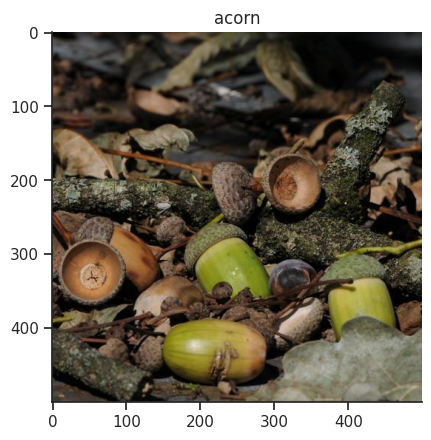

In [175]:
idx=3
plt.imshow(Image.open(img_test[idx]))
plt.title(syn_to_class[label_test_encoded[idx]])



processing 0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


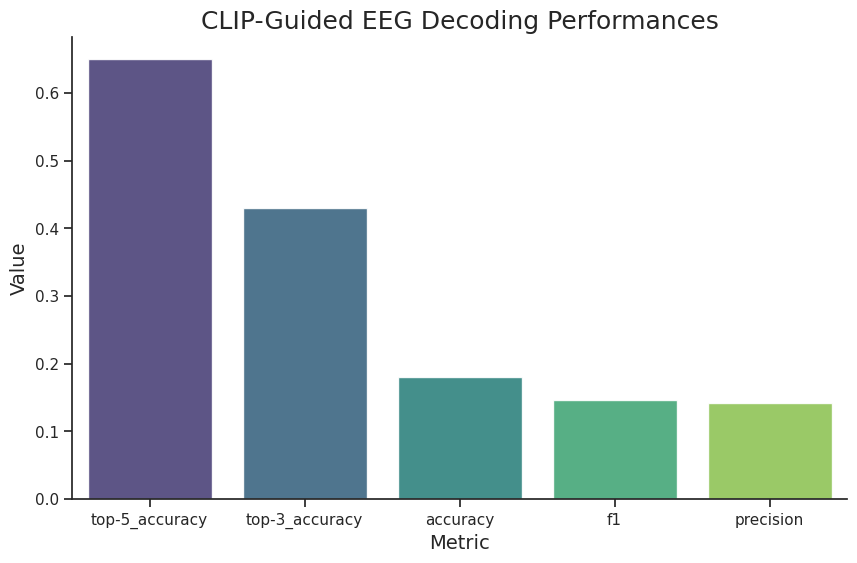

accuracy: 0.18
top-3_accuracy: 0.43
top-5_accuracy: 0.65
f1: 0.14703370953370953
precision: 0.1418148148148148


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
aardvark,0.148148,0.40,0.216216,10.00
abacus,0.333333,0.20,0.250000,10.00
accordion,0.000000,0.00,0.000000,10.00
acorn,0.000000,0.00,0.000000,10.00
air_conditioner,0.000000,0.00,0.000000,10.00
air_mattress,0.120000,0.30,0.171429,10.00
air_pump,0.200000,0.20,0.200000,10.00
airbag,0.166667,0.10,0.125000,10.00
airboat,0.200000,0.20,0.200000,10.00
airplane,0.250000,0.40,0.307692,10.00


In [176]:


def compute_metrics(preds, true_labels):
    # Compute accuracy
    accuracy = accuracy_score(true_labels, np.argmax(preds, axis=1))

    # Get the indices of the top 5 predicted classes for each sample
    top3_indices = np.argsort(preds, axis=1)[:, -3:]

    # Check if the true label is present in the top 5 predicted classes
    top3_accuracy = np.mean(np.any(top3_indices == true_labels.reshape(-1, 1), axis=1))


    # Get the indices of the top 5 predicted classes for each sample
    top5_indices = np.argsort(preds, axis=1)[:, -5:]

    # Check if the true label is present in the top 5 predicted classes
    top5_accuracy = np.mean(np.any(top5_indices == true_labels.reshape(-1, 1), axis=1))

    # Compute F1 score
    f1 = f1_score(true_labels, np.argmax(preds, axis=1), average='macro')

    # Compute precision
    precision = precision_score(true_labels, np.argmax(preds, axis=1), average='macro')

    # Compute recall
    recall = recall_score(true_labels, np.argmax(preds, axis=1), average='macro')

    return accuracy, top3_accuracy,top5_accuracy, f1, precision, recall

subj_idx=0
metrics={}
for subj_idx in [0]:
    
    print(f"processing {subj_idx}")
    # base_model = nets.Classifier(in_shape=(4,17,32,32),classes=10,channels=[64,64,128,128,128,128],strides=[2,1,2,1,2,2],kernel_size=3, num_res_units=1, act='GELU', norm="BATCH", dropout=0.)
    model= CNNClassifier(base_model,teaching_clip_head=clip_head_classifier,lr=3e-4,distill_knowledge=True)
    model.load_state_dict(torch.load(f"models/subj_{subj_idx}.pt")["state_dict"])
    
    inputs= torch.stack([spec_transforms(i) for i in spectro_test[subj_test_array==subj_idx]]).float()
    with torch.no_grad():
        preds=model(inputs)
    
    metric_values=compute_metrics(preds.numpy(),np.array(label_test_encoded)[subj_test_array==subj_idx])
    metrics[f"subj_{subj_idx}"]={"accuracy":metric_values[0],
                                 "top-3_accuracy":metric_values[1],
                                 "top-5_accuracy":metric_values[2],
                                 "f1":metric_values[3],
                                 "precision":metric_values[4],
                                 "recall":metric_values[5],
                                 "preds":preds.argmax(-1).numpy(),
                                 "labels":np.array(label_test_encoded)[subj_test_array==subj_idx]
                                }
                                 
                                 
                                 

df=pd.DataFrame.from_dict(metrics)
df

df_metrics=df.iloc[:5].transpose()

df_metrics.to_csv("report.csv")

# Set a theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a barplot

sns.barplot( data=df_metrics.sort_values(by="subj_0",axis=1, ascending=False), palette='viridis', ax=ax,alpha=0.9)

# Add labels and title
ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('CLIP-Guided EEG Decoding Performances', fontsize=18)

# Show the plot
plt.show()
# plt.savefig("figures/performances.png")

report=classification_report(np.array(label_test_encoded)[subj_test_array==subj_idx],preds.argmax(-1).numpy(),output_dict=True,target_names=class_names)
df = pd.DataFrame(report).transpose()
# Print first 5 values from the metrics dictionary
for i, (key, value) in enumerate(metrics[f"subj_{subj_idx}"].items()):
    if i >= 5:
        break
    print(f"{key}: {value}")
df



In [177]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

repo_id = "stabilityai/stable-diffusion-2-base"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

img_test_subj=np.array(img_test)[subj_test_array==subj_idx]


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:325: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-base via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-base currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-base is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


NameError: name 'device' is not defined

In [ ]:
metrics["subj_0"]
len(metrics["subj_0"]["preds"])

In [ ]:
decoded_images={}
test_images={}
for subj_idx in [0]:
    print(f"processing {subj_idx}")
    img_test_subj=np.array(img_test)[subj_test_array==subj_idx]
    key=f"subj_{subj_idx}"
    
    subj_imgs=[]
    for p in metrics[key]["preds"][0:5]:
        prompt = f"High quality photo of {syn_to_class[p]}"
        image = pipe(prompt, num_inference_steps=40,guidance_scale=9,negative_prompt="bad quality,poor resolution").images[0]
        subj_imgs.append(image)
    decoded_images[key]=subj_imgs
    test_images[key]=[Image.open(i) for i in img_test_subj]

np.array(decoded_images[f"subj_0"]).__len__()


In [ ]:
import matplotlib.pyplot as plt

def plot_images(test_images, decoded_images, subj_key="subj_0"):
    # Get the images for the specified subject
    test_imgs = test_images[subj_key]
    decoded_imgs = decoded_images[subj_key]
    
    # Determine number of pairs to plot (minimum of both)
    num_pairs = min(len(test_imgs), len(decoded_imgs))
    
    # Create figure
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))
    
    # If only one pair, adjust axes array
    if num_pairs == 1:
        axes = axes.reshape(1, 2)
    
    # Plot each pair
    for i in range(num_pairs):
        # Test image
        axes[i, 0].imshow(test_imgs[i])
        axes[i, 0].set_title(f"Test Image {i+1}")
        axes[i, 0].axis('off')
        
        # Decoded image
        axes[i, 1].imshow(decoded_imgs[i])
        axes[i, 1].set_title(f"Decoded Image {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
 

# Usage
plot_images(test_images, decoded_images, "subj_0")
